In [54]:
from __future__ import print_function

from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from keras import applications
import cv2 
from os import listdir
import numpy as np
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, AveragePooling2D
from keras.models import Model
import pywt

In [2]:
root_directory = "G:\\DS\\3.Personal_Projects\\Covid_Classification\\Data"

train_data=[]
test_data=[]
train_label=[]
test_label=[]

img_row,img_col = 32,32

num_of_classes = 2

data_type =["train","test"]
folder_names=["covid_without_PNEUMONIA","covid_with_PNEUMONIA"]
label_mapping={"covid_without_PNEUMONIA":0,"covid_with_PNEUMONIA":1}

In [3]:
def w2d(img, mode='haar', level=1):
    imArray = img

    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;

    coeffs=pywt.wavedec2(imArray, mode, level=level)


    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

In [4]:
def process_img(dataset,folder,filename): 
    file_path = root_directory+"\\"+dataset+"\\"+folder+"\\"+filename
    img = cv2.imread(file_path)
    scalled_raw_img = cv2.resize(img, (32, 32))
    img_har = w2d(img,'db1',5)
    scalled_img_har = cv2.resize(img_har, (32, 32))
    combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
    return combined_img  

In [5]:
for dataset in data_type:
    for folder in folder_names:
        for filename in listdir(root_directory+"\\"+dataset+"\\"+folder+"\\"):
            if dataset is "train":
                train_data.append((process_img(dataset,folder,filename))/255)
                train_label.append(label_mapping[folder])
            else:
                test_data.append((process_img(dataset,folder,filename))/255)
                test_label.append(label_mapping[folder])


In [6]:
train_data = np.asarray(train_data)
train_label = np.asarray(train_label)

test_data = np.asarray(test_data)
test_label = np.asarray(test_label)

In [7]:
X_train = train_data
X_test = test_data

y_train = train_label 
y_test = test_label 

In [8]:
X_train = np.array(X_train).reshape(len(X_train),4096).astype(float)
X_test = np.array(X_test).reshape(len(X_test),4096).astype(float)

In [9]:

import pandas as pd
import pandas_profiling as pp
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

In [14]:

#itterating to find the best k value
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([1.  , 0.98, 1.  , 1.  , 0.99, 1.  , 0.95, 0.95, 0.95])

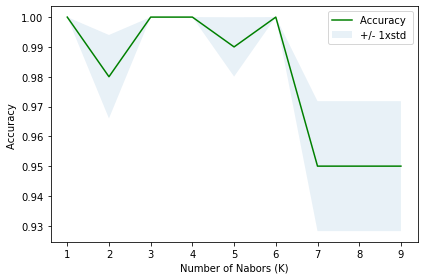

In [15]:

#Plot model accuracy for Different number of Neighbors

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10) #showing 68% data
plt.legend(('Accuracy ', '+/- 1xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [33]:
scores=[]
best_estimators = {}


model_params = {  
    

    'KNeighborsClassifier': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [4,5,6],
            'algorithm' : ['auto','ball_tree','kd_tree'],
            'weights' : ['uniform','distance'],
            'leaf_size' : [27,26,25,24,23,22,21,20,19]
        }
    },
    
    'DecisionTreeClassifier': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini','entropy'],
            'max_depth' : [9,10,11,12,13,14]
        }
    },
    
    
    'AdaBoostClassifier': {
        'model': AdaBoostClassifier(),
        'params': {
            'n_estimators': [40,41,42,43],
            'learning_rate' : [0.8],
            'algorithm' : ['SAMME', 'SAMME.R']
        }
    },
    
    'GaussianNB': {
        'model': GaussianNB(),
        'params': {
            
        }
    },
    
     'LOGISTIC_REGRESSION': {
        'model': LogisticRegression(max_iter=500),
        'params': {
            'C': [1,2,3],
            'solver' : [ 'liblinear', 'lbfgs'],
            'multi_class' : ['auto', 'ovr' ]
        }
    },
    
        
    'SVM': {
        'model': SVC(),
        'params': {
             'C': [5,6,7,8,9],
             'kernel': ['rbf','linear'],
             'gamma': ['auto', 'scale']
        }
    },
       
    'RANDOM_FOREST':{
        'model' : RandomForestClassifier(),
        'params': {
            'n_estimators':[12,7,8,9,11,10,13,14,16],
            'criterion': ['entropy'],
            'random_state' : [14,15,13,16],
            'max_depth' : [7,8,6,9]

        }
    }
}

In [34]:
import time


for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    print(mp['model'], mp['params'])
    start_time = time.time()
    
    clf.fit(X_train, y_train)    
    

    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': str(clf.best_params_)
    })
    best_estimators[model_name] = clf.best_estimator_
    print('{} minutes'.format((time.time() - start_time)/60))

KNeighborsClassifier() {'n_neighbors': [4, 5, 6], 'algorithm': ['auto', 'ball_tree', 'kd_tree'], 'weights': ['uniform', 'distance'], 'leaf_size': [27, 26, 25, 24, 23, 22, 21, 20, 19]}
6.060552100340526 minutes
DecisionTreeClassifier() {'criterion': ['gini', 'entropy'], 'max_depth': [9, 10, 11, 12, 13, 14]}
0.6423404773076375 minutes
AdaBoostClassifier() {'n_estimators': [40, 41, 42, 43], 'learning_rate': [0.8], 'algorithm': ['SAMME', 'SAMME.R']}
3.2342342178026837 minutes
GaussianNB() {}
0.00426172415415446 minutes
LogisticRegression(max_iter=500) {'C': [1, 2, 3], 'solver': ['liblinear', 'lbfgs'], 'multi_class': ['auto', 'ovr']}
0.2952975153923035 minutes
SVC() {'C': [5, 6, 7, 8, 9], 'kernel': ['rbf', 'linear'], 'gamma': ['auto', 'scale']}
0.6902692635854085 minutes
RandomForestClassifier() {'n_estimators': [12, 7, 8, 9, 11, 10, 13, 14, 16], 'criterion': ['entropy'], 'random_state': [14, 15, 13, 16], 'max_depth': [7, 8, 6, 9]}
1.1643612504005432 minutes


In [35]:

import pandas as pd    
df2 = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df2 = df2.sort_values(by='best_score',ascending=False)
df2

,model,best_score,best_params
6,RANDOM_FOREST,0.936609,"{'criterion': 'entropy', 'max_depth': 6, 'n_es..."
5,SVM,0.933006,"{'C': 9, 'gamma': 'auto', 'kernel': 'rbf'}"
4,LOGISTIC_REGRESSION,0.927617,"{'C': 1, 'multi_class': 'auto', 'solver': 'lbf..."
2,AdaBoostClassifier,0.925782,"{'algorithm': 'SAMME', 'learning_rate': 0.8, '..."
0,KNeighborsClassifier,0.922179,"{'algorithm': 'auto', 'leaf_size': 27, 'n_neig..."
3,GaussianNB,0.904144,{}
1,DecisionTreeClassifier,0.882523,"{'criterion': 'gini', 'max_depth': 14}"


In [102]:
df2.to_csv('ml_model.csv', index=False)

In [42]:
cross_val_score(best_estimators['RANDOM_FOREST'],X_test,y_test,cv=5).mean()

0.9400000000000001

In [43]:
cross_val_score(best_estimators['RANDOM_FOREST'],X_train,y_train,cv=5).mean()

0.9366093366093367

In [44]:
cross_val_score(best_estimators['SVM'],X_test,y_test,cv=5).mean()

0.9600000000000002

In [45]:
cross_val_score(best_estimators['SVM'],X_train,y_train,cv=5).mean()

0.9330057330057329

In [38]:
cross_val_score(best_estimators['KNeighborsClassifier'],X_test,y_test,cv=5).mean()

0.9400000000000001

In [46]:
best_clf = best_estimators['RANDOM_FOREST']
best_clf

RandomForestClassifier(criterion='entropy', max_depth=6, n_estimators=11,
                       random_state=13)

In [47]:
from sklearn.metrics import classification_report
print(classification_report(y_test,best_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



In [48]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[50,  0],
       [ 0, 50]], dtype=int64)

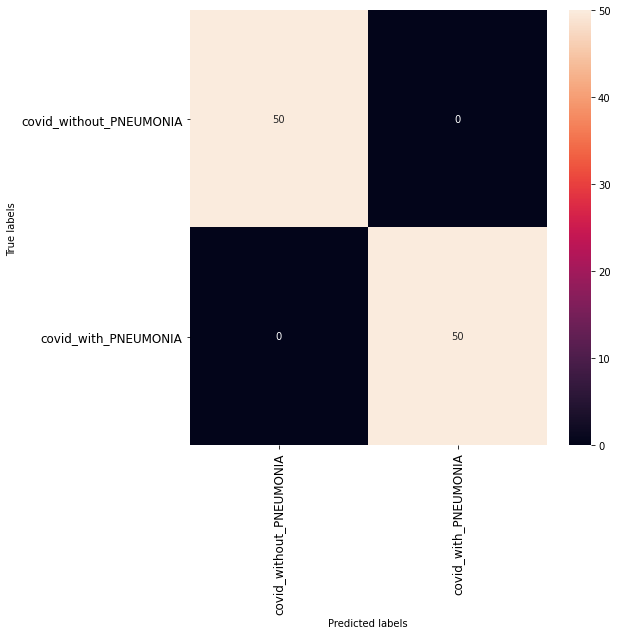

In [49]:
fig, ax = plt.subplots(figsize=(8,8))

g = sns.heatmap(cm,annot=True,ax=ax)
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 12)
g.set_xticklabels(g.get_xticklabels(), rotation = 90, fontsize = 12)
ax.xaxis.set_ticklabels(label_mapping.keys()); ax.yaxis.set_ticklabels(label_mapping.keys());
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');

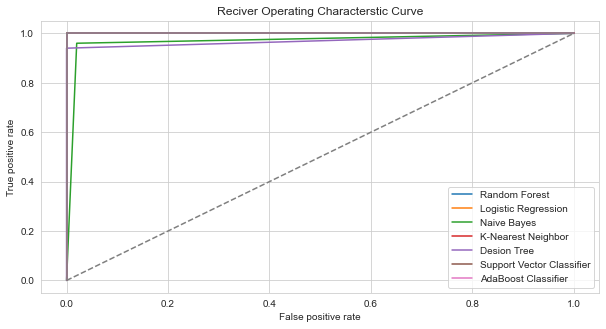

In [50]:

lr_false_positive_rate,lr_true_positive_rate,lr_threshold = metrics.roc_curve(y_test,best_estimators['LOGISTIC_REGRESSION'].predict(X_test))
nb_false_positive_rate,nb_true_positive_rate,nb_threshold = metrics.roc_curve(y_test,best_estimators['GaussianNB'].predict(X_test))
rf_false_positive_rate,rf_true_positive_rate,rf_threshold = metrics.roc_curve(y_test,best_estimators['RANDOM_FOREST'].predict(X_test))                                                             
knn_false_positive_rate,knn_true_positive_rate,knn_threshold = metrics.roc_curve(y_test,best_estimators['KNeighborsClassifier'].predict(X_test))
dt_false_positive_rate,dt_true_positive_rate,dt_threshold = metrics.roc_curve(y_test,best_estimators['DecisionTreeClassifier'].predict(X_test))
svc_false_positive_rate,svc_true_positive_rate,svc_threshold = metrics.roc_curve(y_test,best_estimators['SVM'].predict(X_test))
ada_false_positive_rate,ada_true_positive_rate,ada_threshold = metrics.roc_curve(y_test,best_estimators['AdaBoostClassifier'].predict(X_test))


sns.set_style('whitegrid')
plt.figure(figsize=(10,5))
plt.title('Reciver Operating Characterstic Curve')

plt.plot(rf_false_positive_rate,rf_true_positive_rate,label='Random Forest')
plt.plot(lr_false_positive_rate,lr_true_positive_rate,label='Logistic Regression')
plt.plot(nb_false_positive_rate,nb_true_positive_rate,label='Naive Bayes')
plt.plot(knn_false_positive_rate,knn_true_positive_rate,label='K-Nearest Neighbor')
plt.plot(dt_false_positive_rate,dt_true_positive_rate,label='Desion Tree')
plt.plot(svc_false_positive_rate,svc_true_positive_rate,label='Support Vector Classifier')
plt.plot(ada_false_positive_rate,ada_true_positive_rate,label='AdaBoost Classifier')
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
plt.show()

In [52]:
import joblib 
joblib.dump(best_clf, 'xray_model.pkl')

['xray_model.pkl']

In [53]:
import json
with open("xray_class_dictionary.json","w") as f:
    f.write(json.dumps(label_mapping))

In [68]:
import matplotlib.pyplot as plt
cwthpneu = cv2.imread('G:\\DS\\3.Personal_Projects\\Covid_Classification\\Data\\test\\covid_with_PNEUMONIA\\person33_virus_72.jpeg')
cwthoutpneu = cv2.imread('G:\\DS\\3.Personal_Projects\\Covid_Classification\\Data\\test\\covid_without_PNEUMONIA\\446B2CB6-B572-40AB-B01F-1910CA07086A.jpeg')

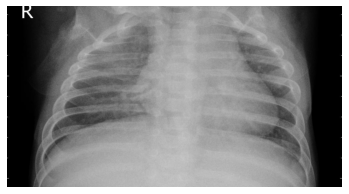

In [64]:
plt.imshow(cwthpneu)
plt.axis('off')
plt.show()

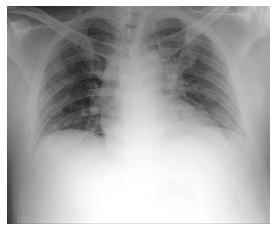

In [65]:
plt.imshow(cwthoutpneu)
plt.axis('off')
plt.show()

In [66]:
def process_img_for_pred(img): 
    scalled_raw_img = cv2.resize(img, (32, 32))
    img_har = w2d(img,'db1',5)
    scalled_img_har = cv2.resize(img_har, (32, 32))
    combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
    return combined_img 

In [91]:
cwthpneu_arr = process_img_for_pred(cwthpneu)/255
cwthoutpneu_arr = process_img_for_pred(cwthoutpneu)/255

In [96]:
def get_key(val):
    for key, value in label_mapping.items():
         if val == value:
             return key
 
    return "key doesn't exist"

In [99]:
get_key(best_clf.predict(cwthpneu_arr.reshape(1,-1))[0])

'covid_with_PNEUMONIA'

In [100]:
get_key(best_clf.predict(cwthoutpneu_arr.reshape(1,-1))[0])

'covid_without_PNEUMONIA'